In [ ]:
from sklearn import datasets
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import os
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
from sklearn.preprocessing import LabelEncoder
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from shapely.geometry import Point
from scipy import stats
import scipy
import joblib
from xgboost import XGBRegressor

C:\Users\zahraghahremani\Miniconda3\envs\SI\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [ ]:
data_train = pd.read_csv("C:\SI22\Width\stream_wdth_all_data_trimmed_v3_train_PUB.csv")
train = data_train.drop(columns=[ 'site_no','Unnamed: 0','COMID','FTYPE','dec_lat_va','dec_long_va','xsec_area_va', 'mean_vel_va',
                                  'Mean_D','SedFluxKgs', 'Avg_K', 'Avg_P', 'Avg_Sin','HUC2','max_vel_va','mean_depth_va', 'max_depth_va'])
data_test = pd.read_csv("C:\SI22\Width\stream_wdth_all_data_trimmed_v3_test_PUB.csv")
test = data_test.drop(columns=[ 'site_no','Unnamed: 0','COMID','FTYPE','dec_lat_va','dec_long_va','xsec_area_va', 'mean_vel_va',
                               'Mean_D','SedFluxKgs', 'Avg_K', 'Avg_P', 'Avg_Sin','HUC2','max_vel_va','mean_depth_va', 'max_depth_va'])
train = train.dropna(axis=0)
test = test.dropna(axis=0)

In [ ]:
train = train[train['q_va'] > 0]
test = test[test['q_va'] > 0]
(test['q_va'] < 0).sum().sum()

0

In [ ]:
X_train = train.drop(columns=['stream_wdth_va'])
X_test = test.drop(columns=['stream_wdth_va'])

y_train = train[["stream_wdth_va"]]
y_test = test[["stream_wdth_va"]]

In [ ]:
y_train = y_train["stream_wdth_va"].to_numpy()
y_test = y_test["stream_wdth_va"].to_numpy()
Columns = X_test.columns.values
X_test = X_test[Columns].to_numpy()
X_train = X_train[Columns].to_numpy()

In [ ]:

D_train = xgb.DMatrix(X_train, label=np.array(y_train))
D_test = xgb.DMatrix(X_test, label=y_test)

In [ ]:
reg = xgb.XGBRegressor()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }
xgb = XGBRegressor( n_jobs=-3, 
                                random_state=42)
grid = GridSearchCV(reg,
                    parameters, n_jobs=-3,
                    scoring="neg_root_mean_squared_error",
                    cv=2)

grid.fit(X_train, y_train)

best_params = grid.best_params_

# # use the selected hyperparameters to define a random forest estimator
best_xgb = XGBRegressor (eta = best_params['eta'], n_jobs=-3, 
                                      max_depth = best_params["max_depth"], 
                                      min_child_weight = best_params["min_child_weight"],
                                      gamma =best_params['gamma'],
                                      colsample_bytree = best_params['colsample_bytree'], random_state=42)
best_xgb.fit(X_train, y_train)
# # filename = 'finalized_model_RF_PUB.sav'
# # joblib.dump(best_forest, path+filename)
print (grid.best_params_, grid.best_score_)
predict=best_xgb.predict(X_test) # make predictions on the test dataset
predict_train=best_xgb.predict(X_train) # make predictions on the training dataset


{'colsample_bytree': 0.5, 'eta': 0.05, 'gamma': 0.0, 'max_depth': 3, 'min_child_weight': 3} -262.06462149555705


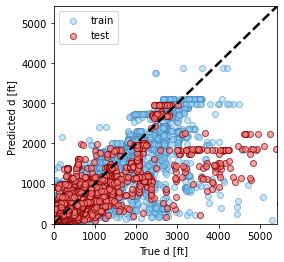

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
lineStart=0
lineEnd=predict_train.max()
plt.scatter(y_train,predict_train,color='lightskyblue',alpha=0.5,edgecolor='steelblue', label = 'train')
plt.scatter(y_test,predict, color="lightcoral",alpha=0.7,edgecolor='darkred', label = 'test')
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], '--', color = 'black',linewidth=2.5) # 45 degree line
plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)
plt.xlabel('True d [ft] ')
plt.ylabel('Predicted d [ft] ')
plt.legend()
# plt.title('linear')
plt.show()


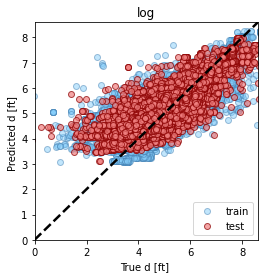

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
lineStart=0
lineEnd=np.log(predict_train.max())
plt.scatter(np.log(y_train),np.log(predict_train),color='lightskyblue',alpha=0.5,edgecolor='steelblue',label = 'train')
plt.scatter(np.log(y_test),np.log(predict), color="lightcoral",alpha=0.7,edgecolor='darkred', label = 'test')
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], '--', color = 'black',linewidth=2.5) # 45 degree line
plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)
plt.xlabel('True d [ft] ')
plt.ylabel('Predicted d [ft] ')
plt.legend()
plt.title('log')
plt.show()

In [ ]:
print("NSE")
print(sklearn.metrics.r2_score(y_train, predict_train))
print(sklearn.metrics.r2_score(y_test,predict))
print("R2")
slope, intercept, r, p, se = scipy.stats.linregress(y_train,predict_train)
print(r**2)
slope, intercept, r, p, se = scipy.stats.linregress(y_test,predict)
print(r**2)
print("log-r2")
slope, intercept, r, p, se = scipy.stats.linregress(np.log(y_train),np.log(predict_train))
print(r**2)
slope, intercept, r, p, se = scipy.stats.linregress(np.log(y_test),np.log(predict))
print(r**2)
print("mse")
print(sklearn.metrics.mean_squared_error(y_train,predict_train))
print(sklearn.metrics.mean_squared_error(y_test,predict))
print("mae")
print(sklearn.metrics.mean_absolute_error(y_train,predict_train))
print(sklearn.metrics.mean_absolute_error(y_test,predict))
print('pmbe')
MBE_train = (((np.sum(y_train- predict_train))/len(predict_train))/np.mean(y_train))*100
MBE_test = (((np.sum(y_test- predict))/len(predict))/np.mean(y_test))*100
print(MBE_train )
print(MBE_test)

NSE
0.7013803634482443
0.4340708272235432
R2
0.7044343356762136
0.44243140389754837
log-r2
0.7721509344422318
0.7185242427519393
mse
51517.38005089956
114534.62253058924
mae
77.32276864319893
95.20884774942591


In [ ]:
import os
import joblib

In [ ]:
joblib.dump(best_xgb, "./xgbT.joblib")

['./xgbT.joblib']

In [ ]:
loaded_xgt = joblib.load('C:\\SI22\\xgbT.joblib')

In [ ]:
predict = loaded_xgt.predict(X_test)
predict

array([147.00832, 172.51831, 127.75153, ..., 111.42039, 125.70271,
       121.19026], dtype=float32)

In [ ]:
predict_train = loaded_xgt.predict(X_train)